In [ ]:
!pip install featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 10.9 MB/s eta 0:00:00


In [ ]:
!pip install woodwork

In [ ]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import plotly.express as px
from woodwork.logical_types import Categorical, Double, Integer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from featuretools.primitives import TransformPrimitive
from woodwork.column_schema import ColumnSchema
# from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score



In [ ]:
# SGCredit = pd.read_csv('dz_9/SouthGermanCredit.asc', delimiter=' ')
SGCredit = pd.read_csv('/content/sample_data/SouthGermanCredit.asc', delimiter=' ')



In [ ]:
SGCredit_original = SGCredit.copy()


In [ ]:
SGCredit.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [ ]:
SGCredit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   laufkont  1000 non-null   int64
 1   laufzeit  1000 non-null   int64
 2   moral     1000 non-null   int64
 3   verw      1000 non-null   int64
 4   hoehe     1000 non-null   int64
 5   sparkont  1000 non-null   int64
 6   beszeit   1000 non-null   int64
 7   rate      1000 non-null   int64
 8   famges    1000 non-null   int64
 9   buerge    1000 non-null   int64
 10  wohnzeit  1000 non-null   int64
 11  verm      1000 non-null   int64
 12  alter     1000 non-null   int64
 13  weitkred  1000 non-null   int64
 14  wohn      1000 non-null   int64
 15  bishkred  1000 non-null   int64
 16  beruf     1000 non-null   int64
 17  pers      1000 non-null   int64
 18  telef     1000 non-null   int64
 19  gastarb   1000 non-null   int64
 20  kredit    1000 non-null   int64
dtypes: int64(21)
memory usage: 164.2 KB


In [ ]:
scaler = StandardScaler()
SGCredit_scaled = scaler.fit_transform(SGCredit)

In [ ]:
SGCredit_scaled_original = SGCredit_scaled.copy()


In [ ]:
X = SGCredit[SGCredit.columns].values


In [ ]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne_embedded = tsne.fit_transform(SGCredit)

In [ ]:
fig = px.scatter_3d(
    x=X_tsne_embedded[:, 0],
    y=X_tsne_embedded[:, 1],
    z=X_tsne_embedded[:, 2],
    # color=range(len(X_tsne_embedded)),
    title="t-SNE Visualization of SGCredit Data (3D, Unclustered)",
    labels={'x': 'T-SNE Component 1', 'y': 'T-SNE Component 2', 'z': 'T-SNE Component 3'},
)
fig.update_layout(width=800, height=600)
fig.show()

TSNE данні більш менш валідні мають мають якусь залежність

In [ ]:
tsne_2d = TSNE(n_components=2, random_state=42)
X_tsne_2d = tsne_2d.fit_transform(SGCredit_scaled)

In [ ]:
fig_2d = px.scatter(
    x=X_tsne_2d[:, 0],
    y=X_tsne_2d[:, 1],
    title="t-SNE Visualization of SGCredit Data (2D, Unclustered)",
    labels={'x': 'T-SNE Component 1', 'y': 'T-SNE Component 2'},
)
fig_2d.update_layout(width=800, height=600)
fig_2d.show()

двовимірне TSNE на данних після StandardScaler має більш структорованив вигляд продовжемо роботу використовуючи саме цю конфігурацію

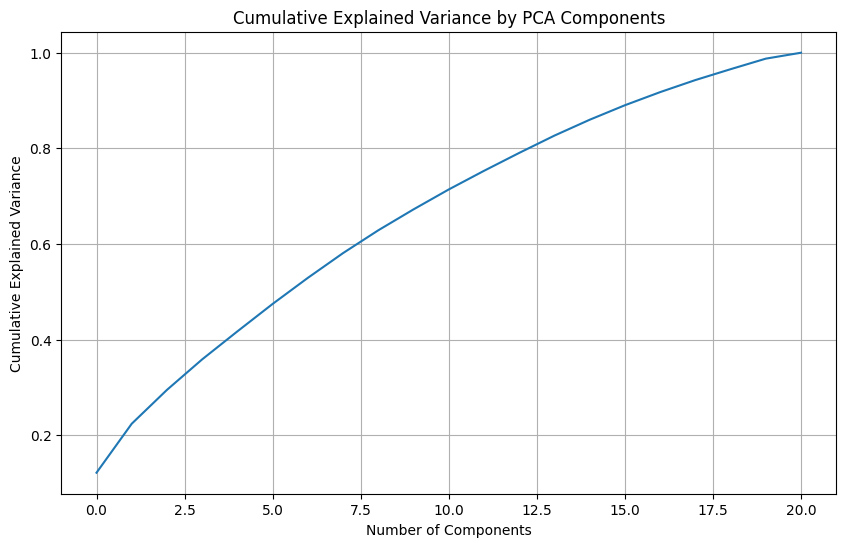

In [ ]:
pca_full = PCA(random_state=42)
pca_full.fit(SGCredit_scaled)
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Графік
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()



PCA продемонстрував що в нас відсутьне плато тому далі глянемо кореляцію та продовжемо  працювати з TSNE

In [ ]:
cumulative_variance_ratio

array([0.12157518, 0.22405317, 0.29484822, 0.35868189, 0.41723995,
       0.47464063, 0.52915295, 0.58097909, 0.62865795, 0.67239425,
       0.71403442, 0.75299657, 0.79048894, 0.82667955, 0.85982615,
       0.89017122, 0.91760072, 0.94282384, 0.96555456, 0.98762585,
       1.        ])

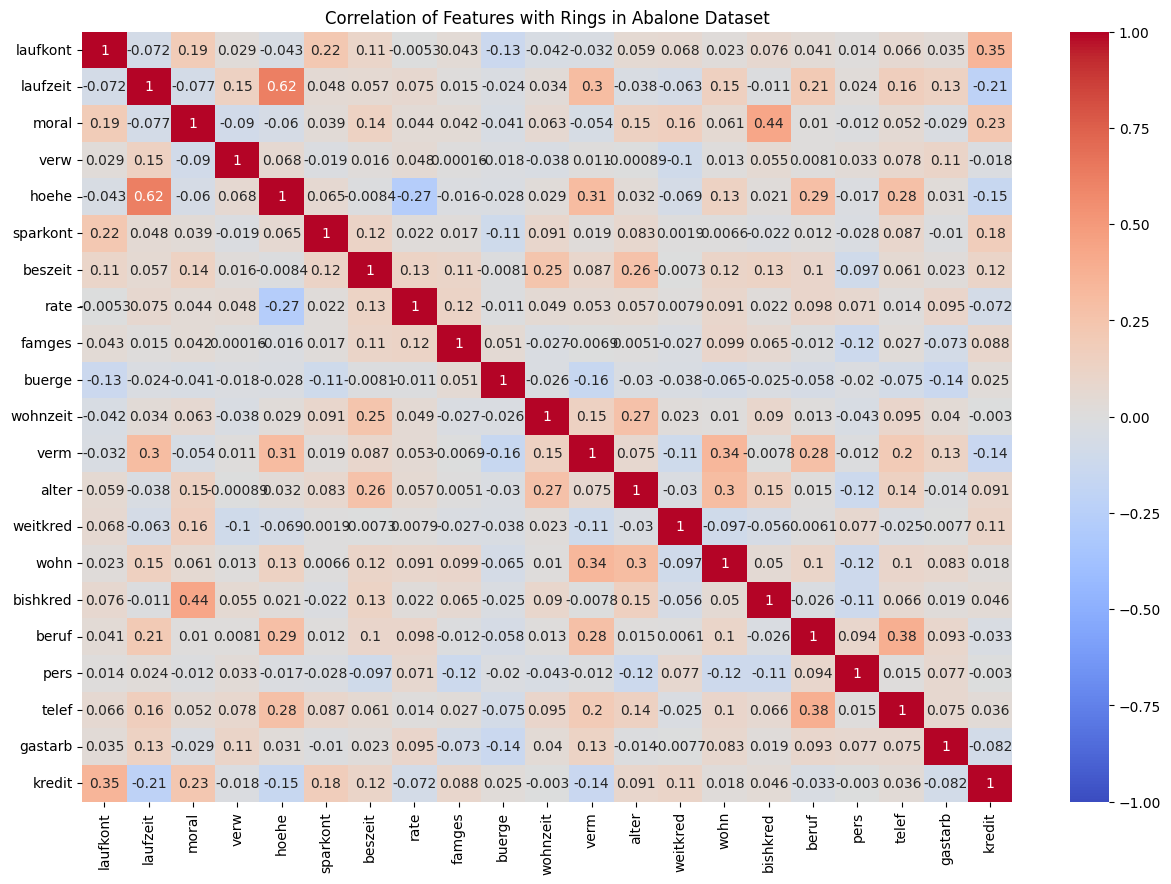

In [ ]:
plt.figure(figsize=(15, 10))
correlation_matrix = SGCredit.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of Features with Rings in Abalone Dataset")
plt.show()

кореляція норм

моделі кластеризації

KMeans

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tsne_2d)

DBSCAN

In [ ]:
dbscan = DBSCAN(eps=2.78, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_tsne_2d)


Spectral Clustering

In [ ]:
spectral = SpectralClustering(n_clusters=7, random_state=42, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(X_tsne_2d)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



Agglomerative Clustering

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative_labels = agglomerative.fit_predict(X_tsne_2d)

In [ ]:
def plot_2d_clusters(X_embedded, labels, title):
    fig = px.scatter(
        x=X_embedded[:, 0],
        y=X_embedded[:, 1],
        color=labels.astype(str),
        title=title,
        labels={'x': 'Component 1', 'y': 'Component 2'},
    )
    fig.update_layout(width=800, height=600)
    fig.show()

In [ ]:
plot_2d_clusters(X_tsne_2d, kmeans_labels, "KMeans Clustering (3D t-SNE)")
plot_2d_clusters(X_tsne_2d, dbscan_labels, "DBSCAN Clustering (3D t-SNE)")
plot_2d_clusters(X_tsne_2d, spectral_labels, "Spectral Clustering (3D t-SNE)")
plot_2d_clusters(X_tsne_2d, agglomerative_labels, "Agglomerative Clustering (3D t-SNE)")

з візуалізації бачимо що KMeans впорався найгірше а за допомогою підбору гіперпараметрів якість DBSCAN є найкращою Agglomerative посідає друге місце він непогано розділив верхню долю основної маси а от з островками промахнувся що ж до Spectral Clustering він погано себе показує на малих кількостях класів тільки після збільшення кількость він непогано впорався

In [ ]:
def evaluate_clustering(X, clustering_method, max_clusters=10):
    """SpectralClustering
    clustering_method
    обчислення метрик
    (silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores)
     для різних чисел кластерів"""
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    cluster_ranges = range(2, max_clusters + 1)

    for n_clusters in cluster_ranges:
        if clustering_method == SpectralClustering:
            model = SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors', n_neighbors=10)
        elif clustering_method == AgglomerativeClustering:
            model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(X)

        if len(np.unique(labels)) > 1:
            silhouette_scores.append(silhouette_score(X, labels))
            davies_bouldin_scores.append(davies_bouldin_score(X, labels))
            calinski_harabasz_scores.append(calinski_harabasz_score(X, labels))
        else:
            silhouette_scores.append(np.nan)
            davies_bouldin_scores.append(np.nan)
            calinski_harabasz_scores.append(np.nan)

    return cluster_ranges, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores


In [ ]:
def plot_metric(ax, cluster_ranges, scores, metric_name, method_name, color):
    """графік метрики"""
    ax.plot(cluster_ranges, scores, marker='o', color=color, linewidth=2, markersize=8)
    ax.set_xlabel('Number of Clusters', fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f'{method_name} - {metric_name}', fontsize=14, pad=15)
    ax.set_xticks(cluster_ranges)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, max(scores) * 1.2 if not all(np.isnan(scores)) else (0, 1))

In [ ]:

def plot_metrics(cluster_ranges, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores, method_name):
    """метрики Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index, заголовок, відступи """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    plot_metric(ax1, cluster_ranges, silhouette_scores, 'Silhouette Score', method_name, 'blue')

    plot_metric(ax2, cluster_ranges, davies_bouldin_scores, 'Davies-Bouldin Index', method_name, 'red')

    plot_metric(ax3, cluster_ranges, calinski_harabasz_scores, 'Calinski-Harabasz Index', method_name, 'green')

    plt.suptitle(f'{method_name} Metrics', fontsize=16, fontweight='bold', y=1.05)

    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connect

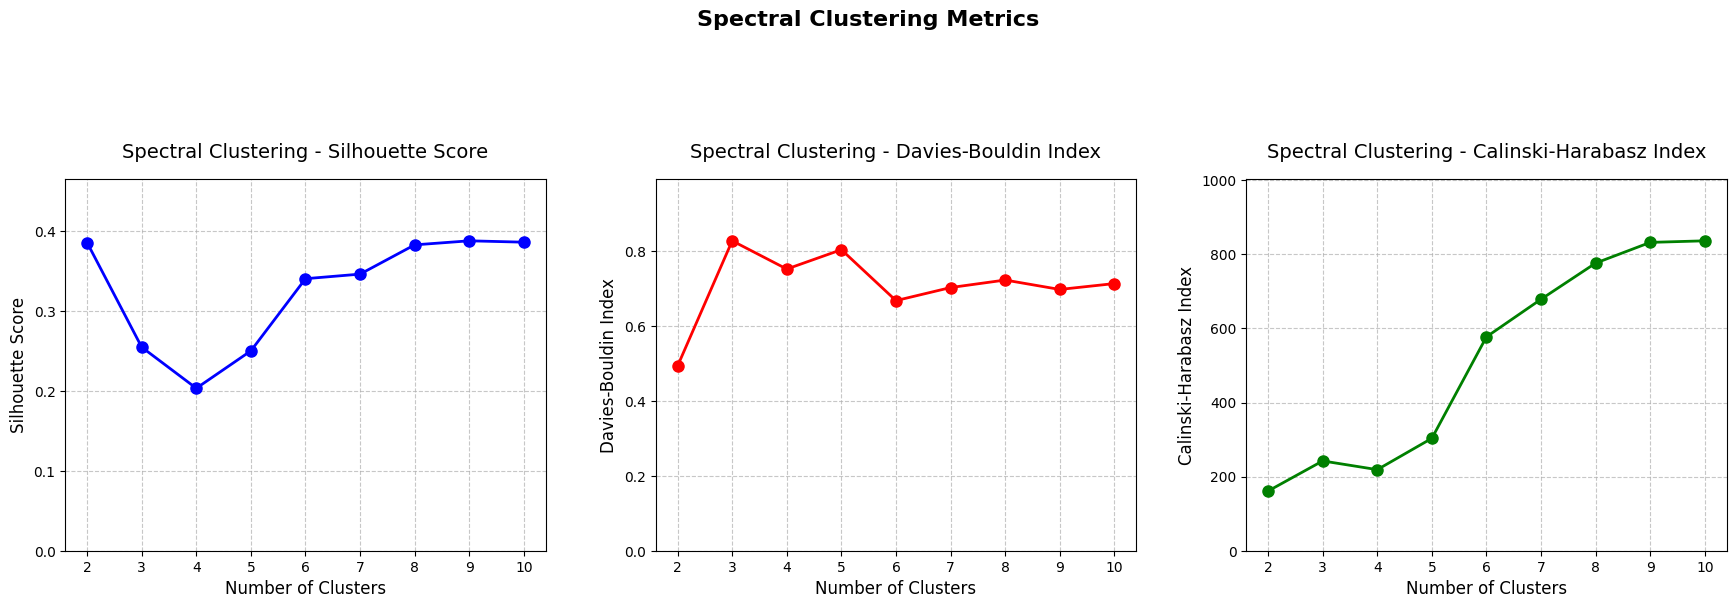

In [ ]:
cluster_ranges_spectral, silhouette_scores_spectral, davies_bouldin_scores_spectral, calinski_harabasz_scores_spectral = evaluate_clustering(X_tsne_2d, SpectralClustering, max_clusters=10)
plot_metrics(cluster_ranges_spectral, silhouette_scores_spectral, davies_bouldin_scores_spectral, calinski_harabasz_scores_spectral, "Spectral Clustering")


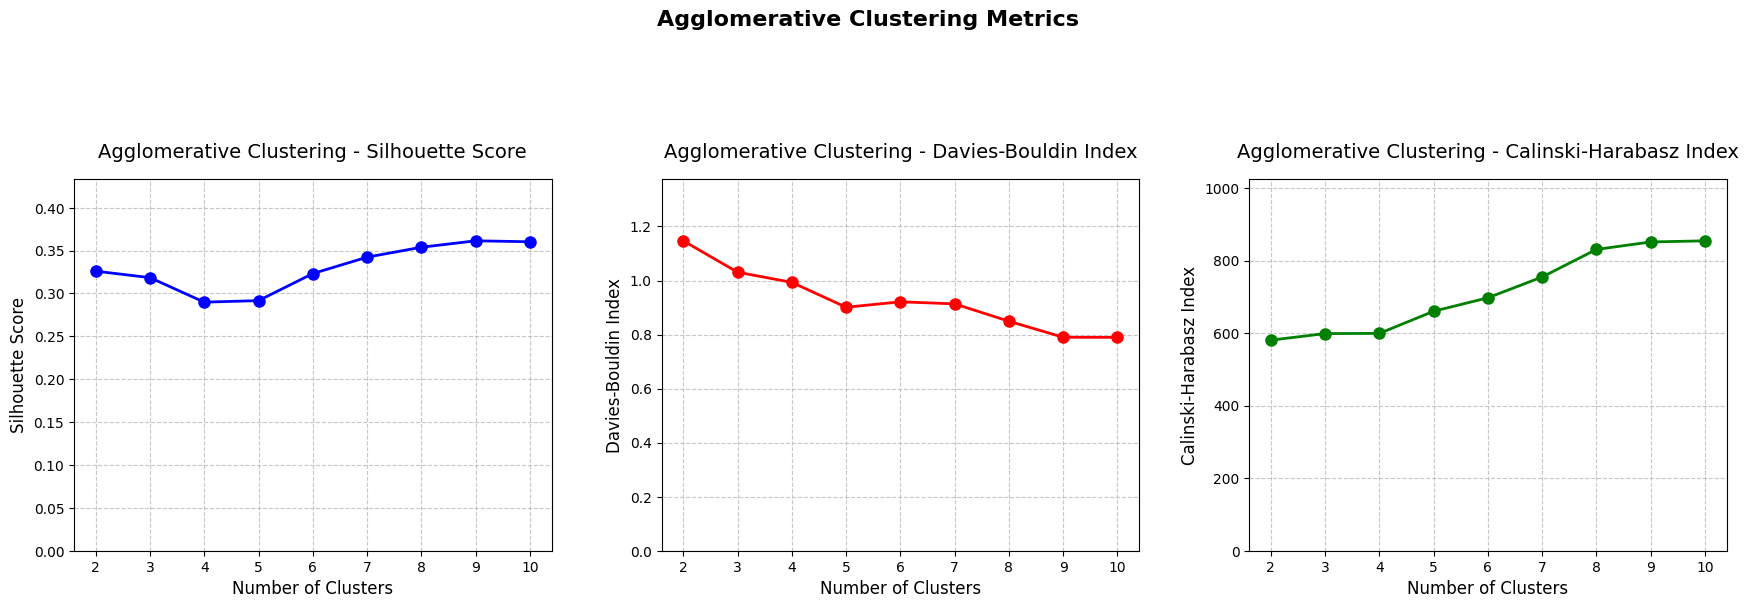

In [ ]:

cluster_ranges_agg, silhouette_scores_agg, davies_bouldin_scores_agg, calinski_harabasz_scores_agg = evaluate_clustering(X_tsne_2d, AgglomerativeClustering, max_clusters=10)
plot_metrics(cluster_ranges_agg, silhouette_scores_agg, davies_bouldin_scores_agg, calinski_harabasz_scores_agg, "Agglomerative Clustering")


ибір оптимальної кількості кластерів

In [ ]:
optimal_clusters_spectral = cluster_ranges_spectral[np.nanargmax(silhouette_scores_spectral)]
optimal_clusters_agg = cluster_ranges_agg[np.nanargmax(silhouette_scores_agg)]
print(f" Spectral Clustering: {optimal_clusters_spectral}")
print(f"Agglomerative Clustering: {optimal_clusters_agg}")

 Spectral Clustering: 9
Agglomerative Clustering: 9


так як і Spectral і Agglomerative показали однаковий результат візьмемо його за істину

In [ ]:
kmeans_m = KMeans(n_clusters=optimal_clusters_spectral, random_state=42)
kmeans_labels_m = kmeans_m.fit_predict(X_tsne_2d)

In [ ]:
spectral_m = SpectralClustering(n_clusters=optimal_clusters_spectral, random_state=42, affinity='nearest_neighbors')
spectral_labels_m = spectral_m.fit_predict(X_tsne_2d)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [ ]:
agglomerative_m = AgglomerativeClustering(n_clusters=optimal_clusters_agg)
agglomerative_labels_m = agglomerative_m.fit_predict(X_tsne_2d)

візуалізація результатів кластеризації після оптимізації кластерів

In [ ]:
plot_2d_clusters(X_tsne_2d, kmeans_labels_m, "KMeans Clustering (3D t-SNE)")
plot_2d_clusters(X_tsne_2d, dbscan_labels, "DBSCAN Clustering (3D t-SNE)")
plot_2d_clusters(X_tsne_2d, spectral_labels_m, "Spectral Clustering (3D t-SNE)")
plot_2d_clusters(X_tsne_2d, agglomerative_labels_m, "Agglomerative Clustering (3D t-SNE)")

бачимо значне покращення з попередньою візуалізацію на мій погляд найкраще впорався Spectral_Cluster

In [ ]:
SGCredit_original['KMeans_Cluster'] = kmeans_labels_m
SGCredit_original['Spectral_Cluster'] = spectral_labels_m
SGCredit_original['Agglomerative_Cluster'] = agglomerative_labels_m
SGCredit_original['DBSCAN_Cluster'] = dbscan_labels
SGCredit_original.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,bishkred,beruf,pers,telef,gastarb,kredit,KMeans_Cluster,Spectral_Cluster,Agglomerative_Cluster,DBSCAN_Cluster
0,1,18,4,2,1049,1,2,4,2,1,...,1,3,2,1,2,1,2,4,3,0
1,1,9,4,0,2799,1,3,2,3,1,...,2,3,1,1,2,1,3,6,6,1
2,2,12,2,9,841,2,4,2,2,1,...,1,2,2,1,2,1,6,4,3,0
3,1,12,4,0,2122,1,3,3,3,1,...,2,2,1,1,1,1,3,5,6,2
4,1,12,4,0,2171,1,3,4,3,1,...,2,2,2,1,1,1,3,5,6,2


In [ ]:
SGCredit_scaled_original = pd.DataFrame(SGCredit_scaled, columns=SGCredit.columns)


In [ ]:
# SGCredit_scaled_original['KMeans_Cluster'] = kmeans_labels_m
# SGCredit_scaled_original['Spectral_Cluster'] = spectral_labels_m
# SGCredit_scaled_original['Agglomerative_Cluster'] = agglomerative_labels_m
# SGCredit_scaled_original['DBSCAN_Cluster'] = dbscan_labels
SGCredit_scaled_original.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,-1.254566,-0.240857,1.344014,-0.301852,-0.787657,-0.699707,-1.145978,0.918477,-0.963650,-0.303686,...,-0.341055,-1.281573,0.460831,-1.751205,-0.704926,0.146949,0.428290,-0.823318,0.196014,0.654654
1,-1.254566,-0.987573,1.344014,-1.030963,-0.167384,-0.699707,-0.317959,-0.870183,0.449326,-0.303686,...,-1.293723,0.040363,0.460831,-1.751205,1.027079,0.146949,-2.334869,-0.823318,0.196014,0.654654
2,-0.459026,-0.738668,-0.503428,2.250036,-0.861381,-0.066488,0.510060,-0.870183,-0.963650,-0.303686,...,-1.293723,-1.105315,0.460831,-1.751205,-0.704926,-1.383771,0.428290,-0.823318,0.196014,0.654654
3,-1.254566,-0.738668,1.344014,-1.030963,-0.407341,-0.699707,-0.317959,0.024147,0.449326,-0.303686,...,-1.293723,0.304750,0.460831,-1.751205,1.027079,-1.383771,-2.334869,-0.823318,-5.101669,0.654654
4,-1.254566,-0.738668,1.344014,-1.030963,-0.389974,-0.699707,-0.317959,0.918477,0.449326,-0.303686,...,-0.341055,0.216621,-2.375050,0.135869,1.027079,-1.383771,0.428290,-0.823318,-5.101669,0.654654


зробимо кілька моделей з таргетом для перевірки роботи наших моделей кластерізації

In [ ]:
SGCredit_scaled_original['Spectral_Cluster'] = spectral_labels_m

X = SGCredit_scaled_original.drop('Spectral_Cluster', axis=1)
y = SGCredit_scaled_original['Spectral_Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
dt_model = DecisionTreeClassifier( criterion='entropy',max_depth=9
                                   , random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))

Decision Tree Accuracy: 0.71
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.73      0.67        55
           1       0.89      0.79      0.84        43
           2       0.66      0.78      0.71        49
           3       0.78      0.78      0.78        18
           4       0.87      0.57      0.68        46
           5       1.00      0.80      0.89        15
           6       0.57      0.80      0.67        10
           7       0.60      0.60      0.60        40
           8       0.65      0.71      0.68        24

    accuracy                           0.71       300
   macro avg       0.74      0.73      0.72       300
weighted avg       0.73      0.71      0.71       300



In [ ]:
SGCredit_scaled_original = pd.DataFrame(SGCredit_scaled, columns=SGCredit.columns)


In [ ]:
SGCredit_scaled_original['Agglomerative_Cluster'] = agglomerative_labels_m

X = SGCredit_scaled_original.drop('Agglomerative_Cluster', axis=1)
y = SGCredit_scaled_original['Agglomerative_Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
dt_model = DecisionTreeClassifier( criterion='entropy',max_depth=11

                                   , random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))

Decision Tree Accuracy: 0.685
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.66      0.72        38
           1       0.54      0.65      0.59        23
           2       0.76      0.57      0.65        23
           3       0.70      0.56      0.62        25
           4       0.73      0.85      0.79        26
           5       0.53      0.62      0.57        26
           6       0.77      0.83      0.80        12
           7       0.81      0.81      0.81        16
           8       0.60      0.82      0.69        11

    accuracy                           0.69       200
   macro avg       0.70      0.71      0.69       200
weighted avg       0.70      0.69      0.69       200



по результатам бачимо що Agglomerative_Cluster показав себе трохи гірше за Spectral_Cluster а саме ці 2 методи найкраще впоралися що можна побачити з візуалізації

In [ ]:
def get_components_for_variance(SGCredit_scaled, variance_threshold):
    """оцінка втрати інформації донеобхіднього (variance_threshold) інформації в датасеті
    плюс графік візуалізації на виході цількість компонент  """
    pca = PCA()
    pca.fit(SGCredit_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    n_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
    print(f"Number of components to retain {variance_threshold*100}% of variance: {n_components}")

    # графік втрати інформації
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='blue', linewidth=2, markersize=8)
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
    plt.title('Loss of Information vs Number of Components (PCA)', fontsize=14, pad=15)
    plt.xticks(range(1, len(cumulative_explained_variance) + 1), fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0, 1.1)
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100}% Variance')
    plt.axvline(x=n_components, color='g', linestyle='--', label=f'{n_components} Components')
    plt.legend()
    plt.show()

    return n_components


Number of components to retain 70.0% of variance: 11


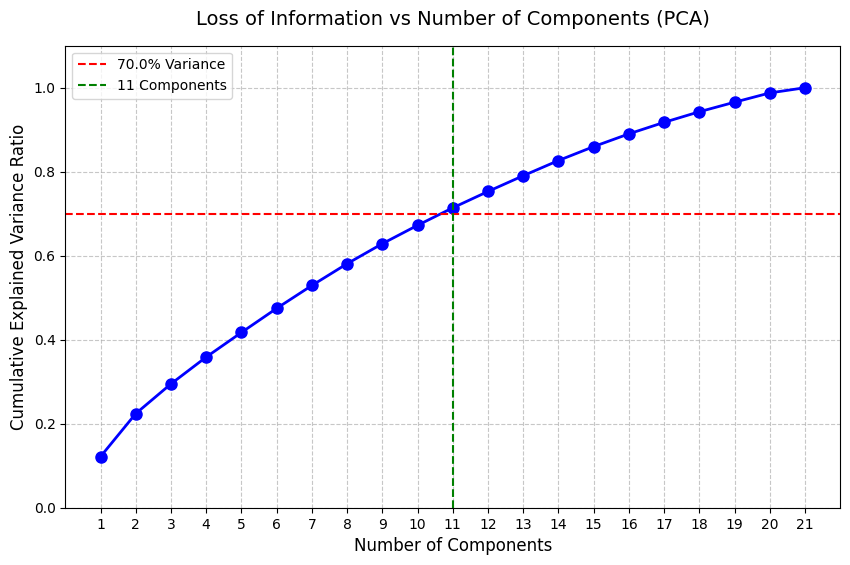

In [ ]:
n_components_70 = get_components_for_variance(SGCredit_scaled, variance_threshold=0.7)


зменшення розмірності до 70%

In [ ]:
pca = PCA(n_components=n_components_70, random_state=42)
X_pca_reduced = pca.fit_transform(SGCredit_scaled)

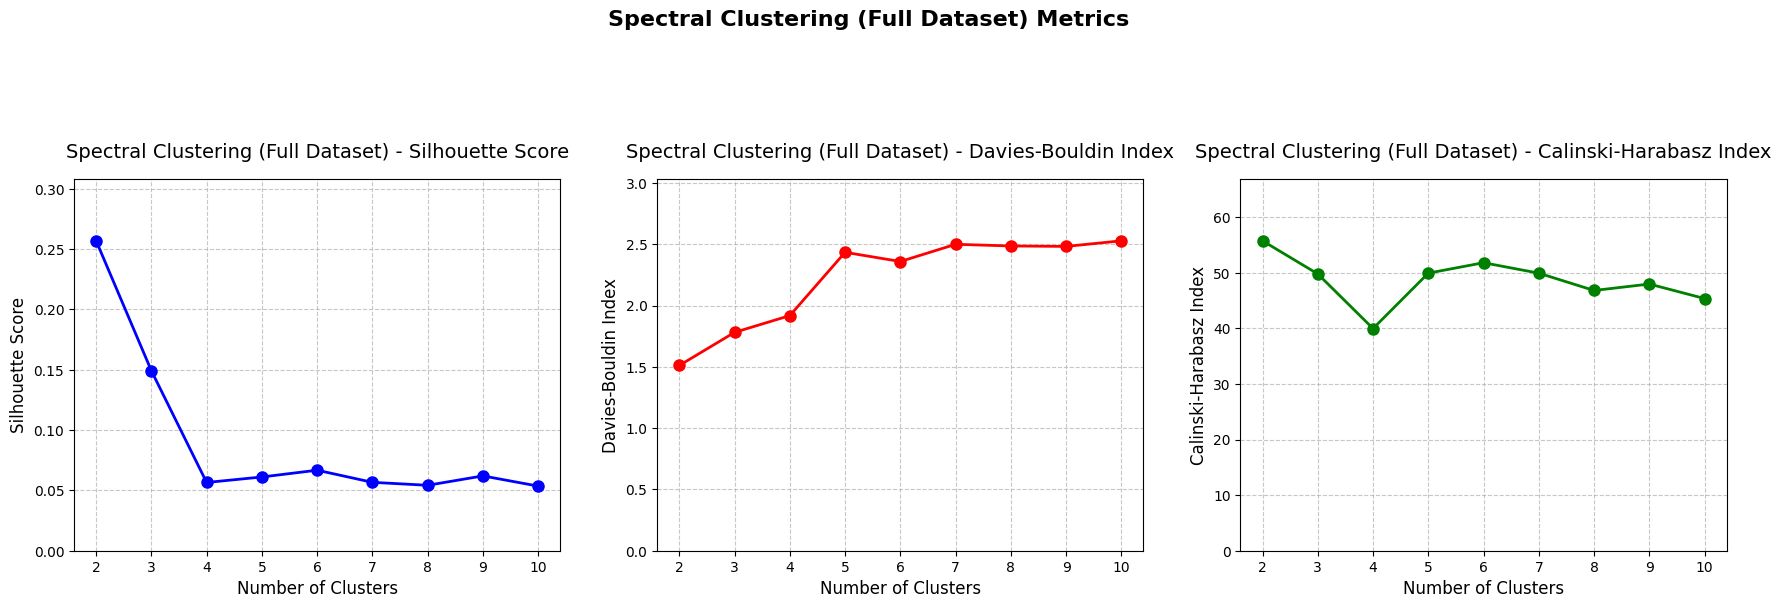

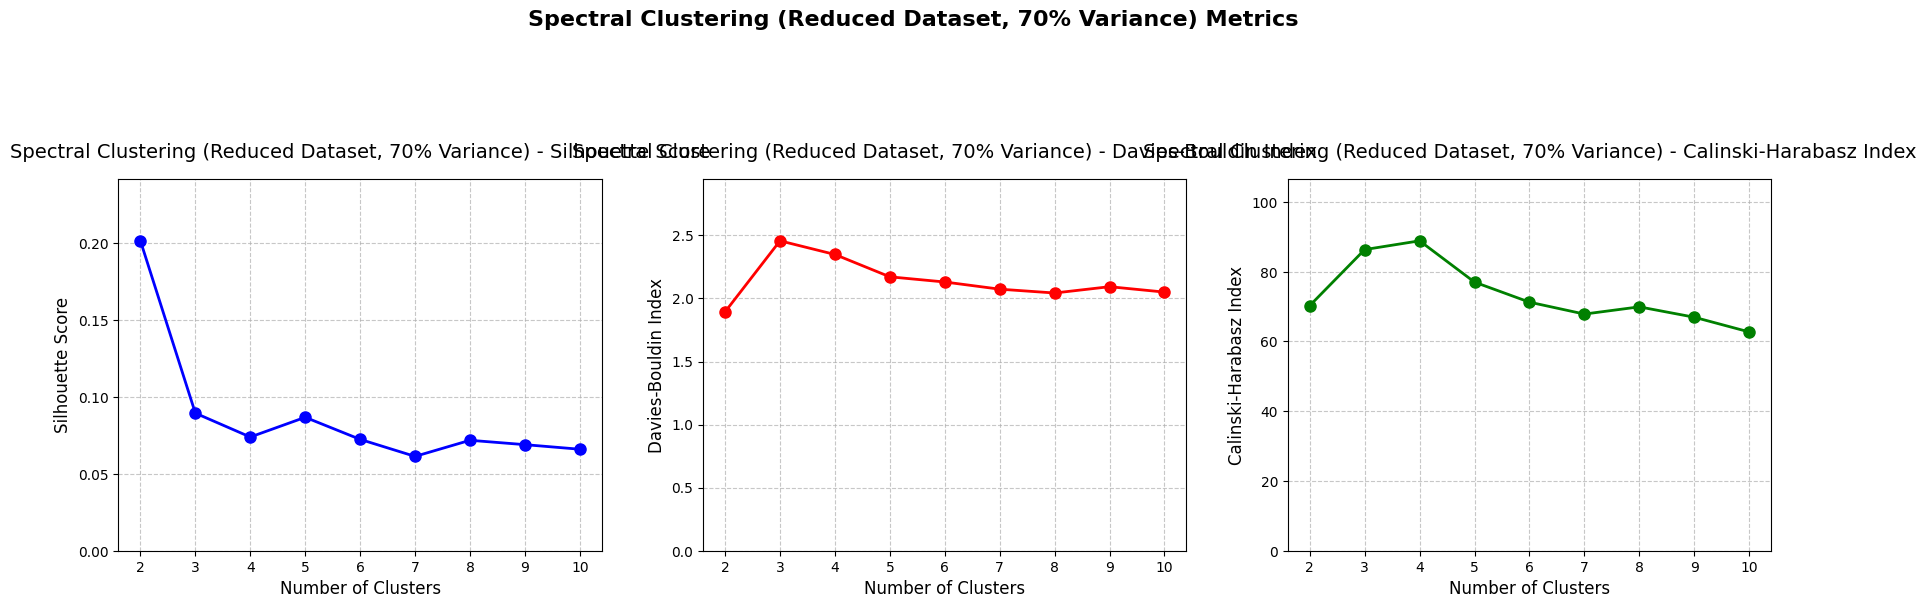

In [ ]:
cluster_ranges_spectral_full, silhouette_scores_spectral_full, davies_bouldin_scores_spectral_full, calinski_harabasz_scores_spectral_full = evaluate_clustering(SGCredit_scaled, SpectralClustering, max_clusters=10)
plot_metrics(cluster_ranges_spectral_full, silhouette_scores_spectral_full, davies_bouldin_scores_spectral_full, calinski_harabasz_scores_spectral_full, "Spectral Clustering (Full Dataset)")

cluster_ranges_spectral_reduced, silhouette_scores_spectral_reduced, davies_bouldin_scores_spectral_reduced, calinski_harabasz_scores_spectral_reduced = evaluate_clustering(X_pca_reduced, SpectralClustering, max_clusters=10)
plot_metrics(cluster_ranges_spectral_reduced, silhouette_scores_spectral_reduced, davies_bouldin_scores_spectral_reduced, calinski_harabasz_scores_spectral_reduced, "Spectral Clustering (Reduced Dataset, 70% Variance)")


вибір оптимальної кількості кластерів

In [ ]:
optimal_clusters_spectral_full = cluster_ranges_spectral_full[np.nanargmax(silhouette_scores_spectral_full)]
optimal_clusters_spectral_reduced = cluster_ranges_spectral_reduced[np.nanargmax(silhouette_scores_spectral_reduced)]
print(f"Optimal number of clusters for Spectral Clustering (Full Dataset): {optimal_clusters_spectral_full}")
print(f"Optimal number of clusters for Spectral Clustering (Reduced Dataset): {optimal_clusters_spectral_reduced}")



Optimal number of clusters for Spectral Clustering (Full Dataset): 2
Optimal number of clusters for Spectral Clustering (Reduced Dataset): 2


In [ ]:
pca_full = PCA(random_state=42)
pca_full_f=pca_full.fit_transform(SGCredit_scaled)
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)


кластеризація повного і зменшеного датасетів за допомогою Spectral Clustering


In [ ]:
spectral_full = SpectralClustering(n_clusters=optimal_clusters_spectral_full, random_state=42, affinity='nearest_neighbors', n_neighbors=10)
spectral_labels_full = spectral_full.fit_predict(pca_full_f)

spectral_reduced = SpectralClustering(n_clusters=optimal_clusters_spectral_reduced, random_state=42, affinity='nearest_neighbors', n_neighbors=10)
spectral_labels_reduced = spectral_reduced.fit_predict(X_pca_reduced)

In [ ]:
SGCredit_scaled_original_pca = pd.DataFrame(SGCredit_scaled, columns=SGCredit.columns)

SGCredit_scaled_original_pca['Spectral_Cluster'] = spectral_labels_full
X = SGCredit_scaled_original_pca.drop('Spectral_Cluster', axis=1)
y = SGCredit_scaled_original_pca['Spectral_Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dt_model = DecisionTreeClassifier( criterion='entropy',max_depth=9
                                   , random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))

Decision Tree Accuracy: 0.9966666666666667
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      0.93      0.97        15

    accuracy                           1.00       300
   macro avg       1.00      0.97      0.98       300
weighted avg       1.00      1.00      1.00       300



In [ ]:
SGCredit_scaled_original_pca_drop = pd.DataFrame(SGCredit_scaled, columns=SGCredit.columns)

SGCredit_scaled_original_pca_drop['Spectral_Cluster'] = spectral_labels_reduced
X = SGCredit_scaled_original_pca_drop.drop('Spectral_Cluster', axis=1)
y = SGCredit_scaled_original_pca_drop['Spectral_Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dt_model = DecisionTreeClassifier( criterion='entropy',max_depth=9
                                   , random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))

Decision Tree Accuracy: 0.9833333333333333
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       273
           1       0.89      0.93      0.91        27

    accuracy                           0.98       300
   macro avg       0.94      0.96      0.95       300
weighted avg       0.98      0.98      0.98       300



при порівнянні урізаного та повного датасетів ми бачимо що при досить значному урізанні інформації на 30 % ми втратитли в Accuracy моделі вссього 1 % що на великих датасетах буде досить корисно але я припускаю що при умовах що кількість кластерів у датасеті буде більшою ніж той оптимум що ми знайшли за допомогою PCA а саме так як показав tsne то якість буде погіршуватись значніше.